In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_palette('pastel')

!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp
plt.style.use("/tmp/rose-pine-dawn.mplstyle")

--2025-05-07 10:06:54--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle.1’

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.003s  

2025-05-07 10:06:54 (14.7 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle.1’ saved [40905/40905]



<a id = "1"></a><br>
<p style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 2px; 
    color: #ffcc80; /* Açık/Canlı Renk (Amber) - Koyu Moda uygun */
    font-size: 180%; 
    text-align: left; 
    padding: 0px; 
    padding-bottom: 5px; /* Metin ile alt çizgi arasına boşluk */
    border-bottom: 3px solid #757575; /* Orta Gri - Koyu Moda uygun */
    margin-bottom: 15px; /* Başlığın altına boşluk */
">
    ✨ Read Data & First Look ✨
</p>

In [5]:
file_path = "/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(file_path)

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [7]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
6362616,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0
6362617,743,CASH_OUT,6311409.280,C1162922333,6311409.280,0.000,C1365125890,68488.840,6379898.110,1,0
6362618,743,TRANSFER,850002.520,C1685995037,850002.520,0.000,C2080388513,0.000,0.000,1,0
6362619,743,CASH_OUT,850002.520,C1280323807,850002.520,0.000,C873221189,6510099.110,7360101.630,1,0


> 📄 **Notes:**
> * step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
> * type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
> * amount - amount of the transaction in local currency.
> * nameOrig - customer who started the transaction
> * oldbalanceOrg - initial balance before the transaction
> * newbalanceOrig - new balance after the transaction.
> * nameDest - customer who is the recipient of the transaction
> * oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
> * newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
> * isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
> * isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
step,6362620.000,243.397,142.332,1.000,35.000,156.000,239.000,335.000,399.000,490.000,681.000,743.000
amount,6362620.000,179861.904,603858.231,0.000,4501.300,13389.570,74871.940,208721.478,365423.309,518634.196,1615979.472,92445516.640
oldbalanceOrg,6362620.000,833883.104,2888242.673,0.000,0.000,0.000,14208.000,107315.175,1822508.289,5823702.278,16027256.134,59585040.370
newbalanceOrig,6362620.000,855113.669,2924048.503,0.000,0.000,0.000,0.000,144258.410,1970344.793,5980262.336,16176160.558,49585040.370
oldbalanceDest,6362620.000,1100701.667,3399180.113,0.000,0.000,0.000,132705.665,943036.708,2914266.669,5147229.713,12371819.155,356015889.350
newbalanceDest,6362620.000,1224996.398,3674128.942,0.000,0.000,0.000,214661.440,1111909.250,3194869.671,5515715.903,13137866.941,356179278.920
isFraud,6362620.000,0.001,0.036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
isFlaggedFraud,6362620.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


> 📄 **Notes:**

> Amount:
> * The average transaction amount is approximately 1.8e+05 (180,000).
> * The standard deviation is quite high (6.04e+05), indicating that the data is spread over a wide range and is likely right-skewed.
> * The minimum is 0.0, while the maximum reaches 9.24e+07 (92.4 million) — this maximum value is a strong outlier candidate.
> * The median (50%) value is 7.49e+04 (74,900), which is significantly lower than the mean. This further supports the right-skewness and presence of outliers.

> isFraud (Our Target Variable):
> * The mean is approximately 0.00129 (1.29e-03).
> * This means that only 0.129% of the transactions are labeled as fraud. The dataset is therefore highly imbalanced.
> * When training a model, this imbalance must be considered — for example, by using special sampling techniques, class weighting, or choosing appropriate evaluation metrics.

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.shape

(6362620, 11)

In [12]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [13]:
df['type'].value_counts(dropna=False)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [14]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6362620.000,NaN,NaN,NaN,243.397,142.332,1.000,156.000,239.000,335.000,743.000
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6362620.000,NaN,NaN,NaN,179861.904,603858.231,0.000,13389.570,74871.940,208721.478,92445516.640
nameOrig,6362620,6353307,C1902386530,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,6362620.000,NaN,NaN,NaN,833883.104,2888242.673,0.000,0.000,14208.000,107315.175,59585040.370
newbalanceOrig,6362620.000,NaN,NaN,NaN,855113.669,2924048.503,0.000,0.000,0.000,144258.410,49585040.370
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,6362620.000,NaN,NaN,NaN,1100701.667,3399180.113,0.000,0.000,132705.665,943036.708,356015889.350
newbalanceDest,6362620.000,NaN,NaN,NaN,1224996.398,3674128.942,0.000,0.000,214661.440,1111909.250,356179278.920
isFraud,6362620.000,NaN,NaN,NaN,0.001,0.036,0.000,0.000,0.000,0.000,1.000


In [15]:
df['isFraud'].value_counts(normalize=True)

isFraud
0   0.999
1   0.001
Name: proportion, dtype: float64

In [16]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

> 📄 **Notes:**
> * These results clearly show that our dataset is extremely imbalanced. Only about 13 out of every 10,000 transactions are fraudulent. This situation requires special attention when selecting model evaluation metrics (e.g., using Precision, Recall, F1-score, AUPRC instead of Accuracy) and when designing modeling strategies (e.g., using sampling techniques like oversampling, undersampling, SMOTE, or applying class weighting).

In [17]:
df['isFlaggedFraud'].value_counts(normalize=True)

isFlaggedFraud
0   1.000
1   0.000
Name: proportion, dtype: float64

In [18]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [19]:
print(df[df['isFraud'] == 1]['type'].value_counts())

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


> 📄 **Notes:**
> * This confirms that all 8,213 fraudulent transactions (4,116 + 4,097) occurred, as expected, in the CASH_OUT and TRANSFER transaction types.
> * Interestingly, the number of fraud cases is almost evenly split between these two types:
    * CASH_OUT transactions account for approximately 50.1% of all fraud cases.
    * TRANSFER transactions make up about 49.9% of all fraud cases.

<a id = "1"></a><br>
<p style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 2px; 
    color: #ffcc80; /* Açık/Canlı Renk (Amber) - Koyu Moda uygun */
    font-size: 250%; 
    text-align: center; 
    padding: 0px; 
    padding-bottom: 5px; /* Metin ile alt çizgi arasına boşluk */
    border-bottom: 3px solid #757575; /* Orta Gri - Koyu Moda uygun */
    margin-bottom: 15px; /* Başlığın altına boşluk */
">
    ✨ EDA ✨
</p>

In [20]:
df['type'] = df['type'].astype('category') # object -> category

print(df['type'].dtype)

category


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;1. Target Variable (isFraud) Distribution&nbsp;</strong>🔹
</h4>

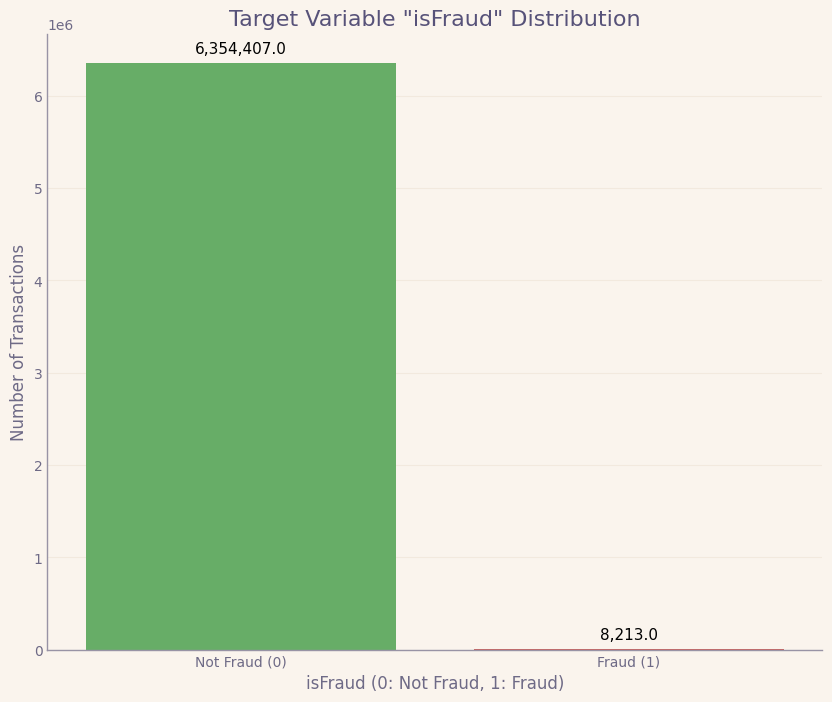

In [21]:
plt.figure(figsize=(10, 8))
sns.countplot(x='isFraud', data=df, palette=['#5cb85c', '#d9534f'])
plt.title('Target Variable "isFraud" Distribution', fontsize=16)
plt.xlabel('isFraud (0: Not Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.show()

> 📄 **Notes:**
> * This visualization clearly highlights the severe class imbalance we previously identified using value_counts(). Non-fraudulent transactions vastly outnumber fraudulent ones, emphasizing once again the need to apply special techniques during the modeling stage.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;2. Transaction Types (type) Distribution&nbsp;</strong>🔹
</h4>

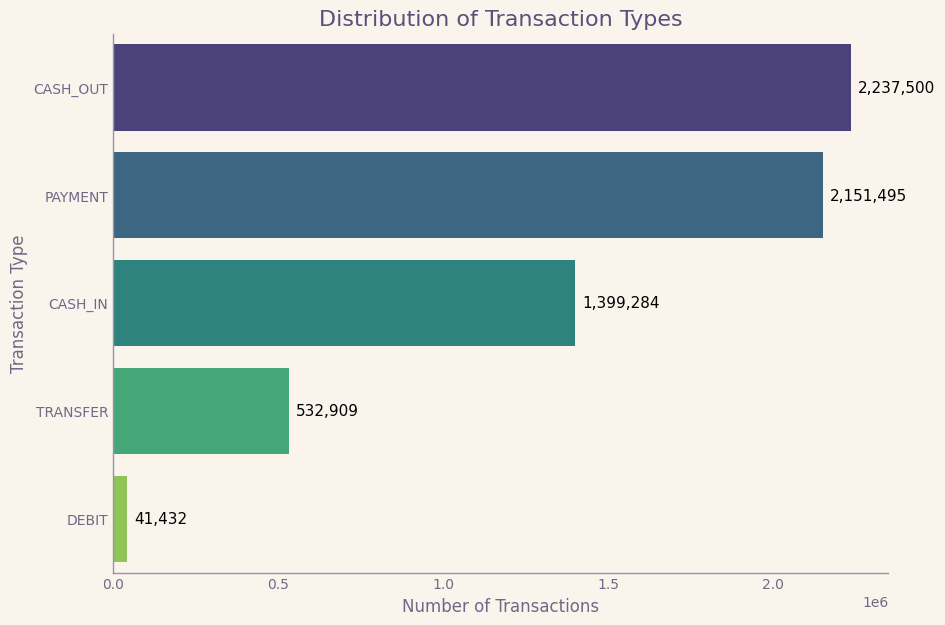

In [22]:
plt.figure(figsize=(10, 7))
sns.countplot(y='type', data=df, order=df['type'].value_counts().index, palette='viridis')
plt.title('Distribution of Transaction Types', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Transaction Type', fontsize=12)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
plt.show()

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;3. "Fraud Status by Transaction Type (type vs isFraud)" & "type_fraud_pivot Table" & "Fraud Rates per Transaction Type (%) Chart"&nbsp;</strong>🔹
</h4>

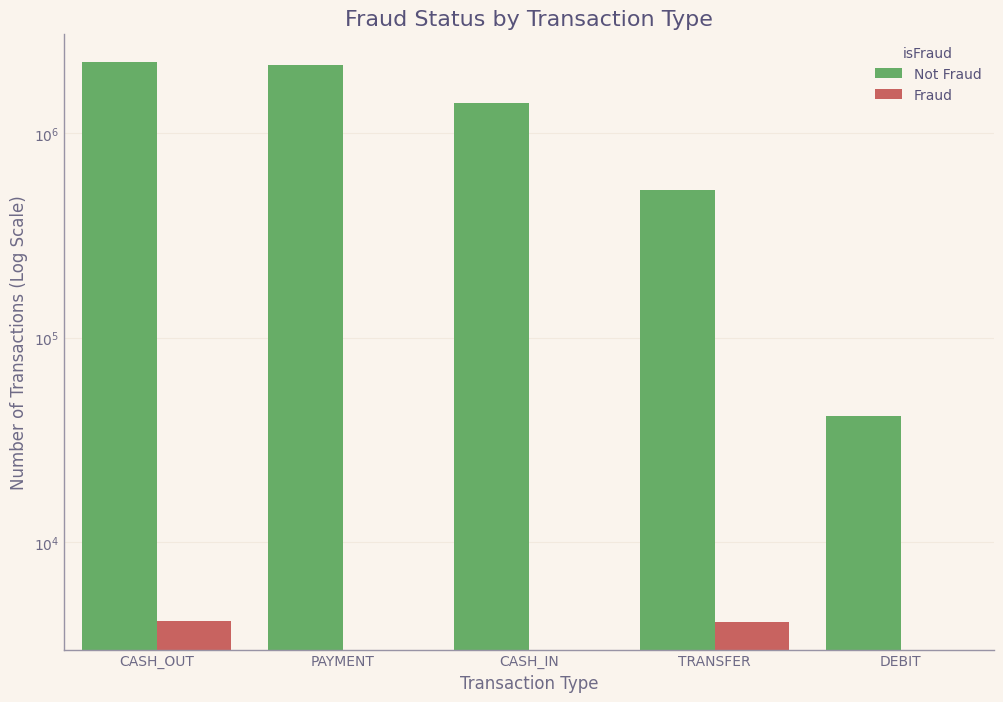

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Fraud Rates by Transaction Type (%):
 isFraud        0     1
type                  
CASH_IN  100.000 0.000
CASH_OUT  99.816 0.184
DEBIT    100.000 0.000
PAYMENT  100.000 0.000
TRANSFER  99.231 0.769
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


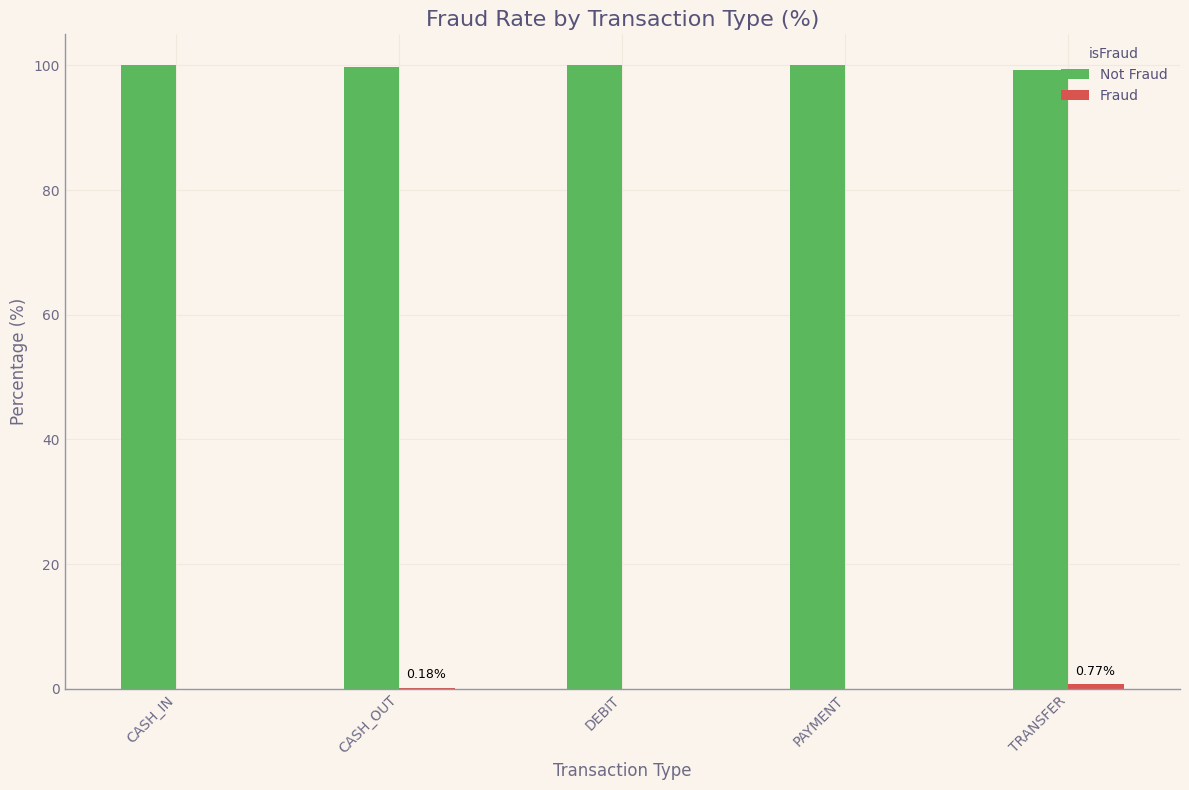

In [23]:
plt.figure(figsize=(12, 8))
sns.countplot(x='type', hue='isFraud', data=df, order=df['type'].value_counts().index, palette={0: '#5cb85c', 1: '#d9534f'})
plt.title('Fraud Status by Transaction Type', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Number of Transactions (Log Scale)', fontsize=12)
plt.yscale('log')
plt.legend(title='isFraud', labels=['Not Fraud', 'Fraud'])
plt.show()

print("-" * 100 + "\n" + "-" * 100)

type_fraud_pivot = pd.crosstab(df['type'], df['isFraud'], normalize='index') * 100
print("\nFraud Rates by Transaction Type (%):\n", type_fraud_pivot)

print("-" * 100 + "\n" + "-" * 100)

type_fraud_pivot.plot(kind='bar', stacked=False, figsize=(12, 8), color=['#5cb85c', '#d9534f'])
plt.title('Fraud Rate by Transaction Type (%)', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='isFraud', labels=['Not Fraud', 'Fraud'])
for i, type_name in enumerate(type_fraud_pivot.index):
    fraud_percentage = type_fraud_pivot.loc[type_name, 1]
    non_fraud_percentage = type_fraud_pivot.loc[type_name, 0]
    if fraud_percentage > 0:
        plt.text(i + 0.12, fraud_percentage + 1, f'{fraud_percentage:.2f}%', color='black', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

> 📄 **Notes:**
> * TRANSFER transactions are proportionally the most risky, with approximately 7–8 out of every 1,000 being fraudulent.
> * CASH_OUT transactions are also risky, but at a lower rate compared to TRANSFER — about 1–2 out of every 1,000 are fraudulent.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;4. Overall Distribution of the "amount" Column&nbsp;</strong>🔹
</h4>

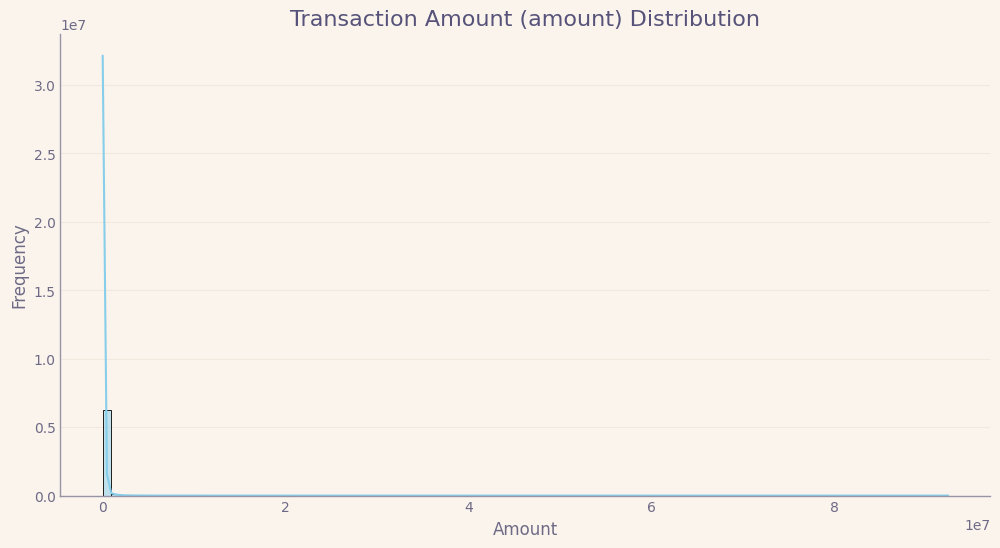

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


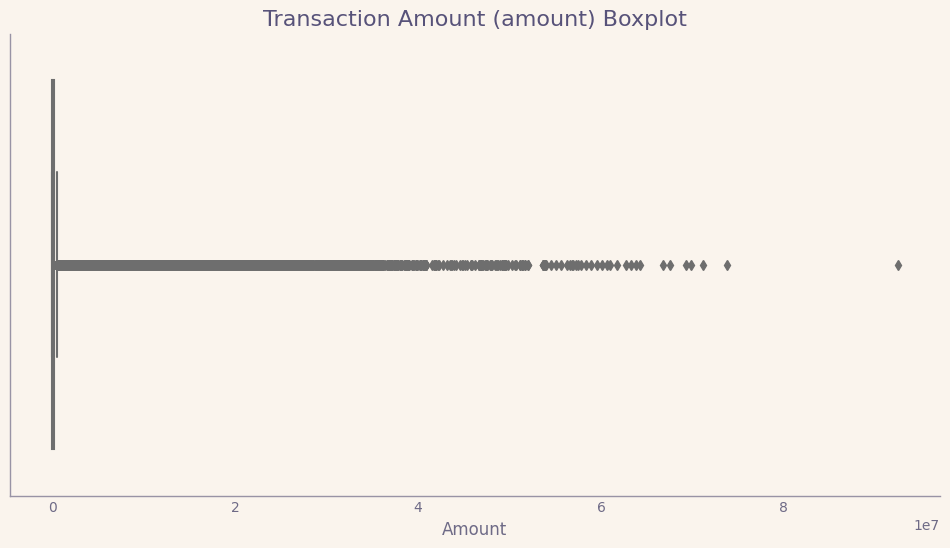

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Basic Statistics for the 'amount' Column:
count    6362620.000
mean      179861.904
std       603858.231
min            0.000
25%        13389.570
50%        74871.940
75%       208721.478
max     92445516.640
Name: amount, dtype: float64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(df['amount'], bins=100, kde=True, color='skyblue')
plt.title('Transaction Amount (amount) Distribution', fontsize=16)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

print("-" * 100 + "\n" + "-" * 100)

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['amount'], color='lightcoral')
plt.title('Transaction Amount (amount) Boxplot', fontsize=16)
plt.xlabel('Amount', fontsize=12)
plt.show()

print("-" * 100 + "\n" + "-" * 100)

print("\nBasic Statistics for the 'amount' Column:")
print(df['amount'].describe())

print("-" * 100 + "\n" + "-" * 100)

> 📄 **Notes:**
> * The high standard deviation and the significant gap between the mean and median observed in the describe() output support the skewness of the "amount" column.
> * This level of skewness can negatively affect the performance of some machine learning algorithms.
> * Applying techniques like logarithmic transformation during visualization and modeling can be beneficial to reduce skewness and stabilize variance.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;5. Creating the Log-Transformed "amount" Column&nbsp;</strong>🔹
</h4>

In [25]:
# Create a new column 'amount_log' for the logarithmic transformation
# Using np.log1p ensures safe computation even when amount is 0 (log1p(x) = log(1 + x))
df['amount_log'] = np.log1p(df['amount'])

print("Basic statistics for the 'amount_log' column:")
print(df['amount_log'].describe())

Basic statistics for the 'amount_log' column:
count   6362620.000
mean         10.841
std           1.815
min           0.000
25%           9.502
50%          11.224
75%          12.249
max          18.342
Name: amount_log, dtype: float64


> 📄 **Notes:**
> * These statistics show that the logarithmic transformation has significantly reduced the scale of the "amount" feature and decreased its skewness. The mean (10.841) and median (11.224) are much closer to each other compared to the original "amount" column, and the standard deviation (1.815) is at a more reasonable level relative to the mean. This means that the amount_log column will be much more suitable for visualizations when comparing distributions.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;6. Comparison of the amount_log Distribution by isFraud&nbsp;</strong>🔹
</h4>

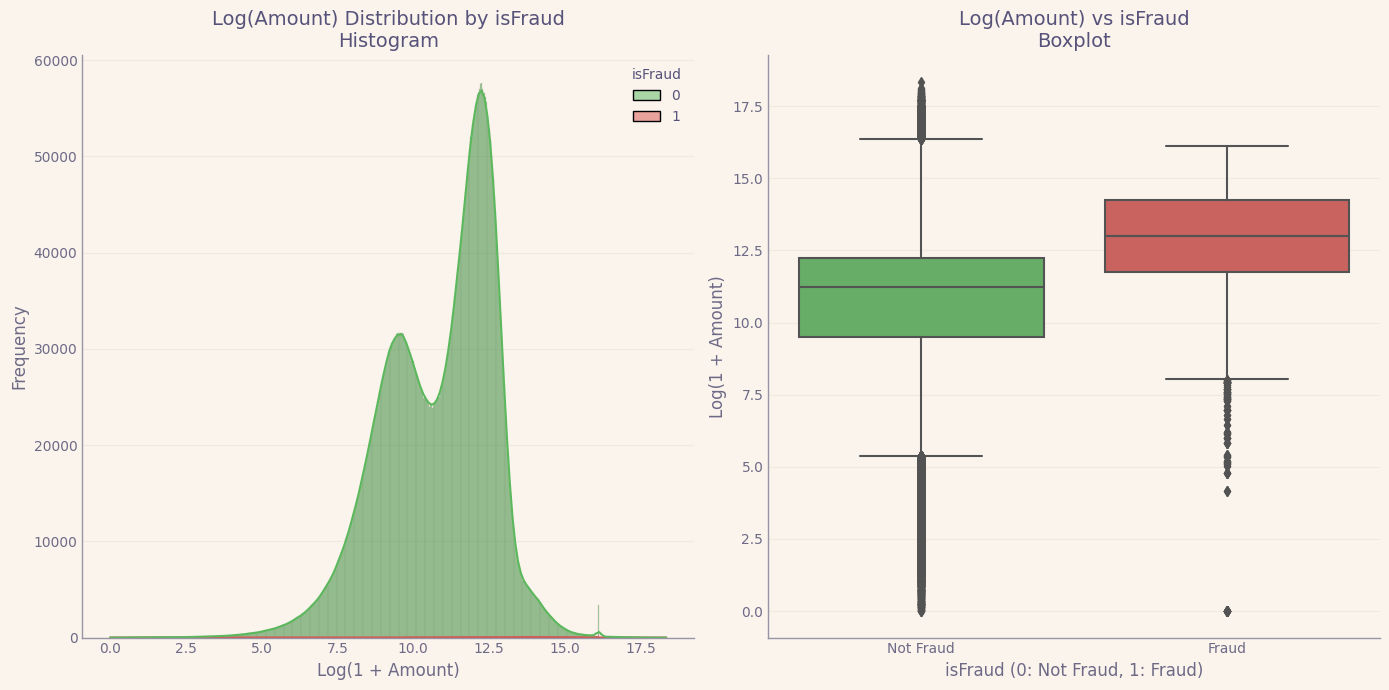

In [26]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='amount_log', hue='isFraud', kde=True, palette={0: '#5cb85c', 1: '#d9534f'}, multiple="stack")
plt.title('Log(Amount) Distribution by isFraud\nHistogram', fontsize=14)
plt.xlabel('Log(1 + Amount)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x='isFraud', y='amount_log', data=df, palette={0: '#5cb85c', 1: '#d9534f'})
plt.title('Log(Amount) vs isFraud\nBoxplot', fontsize=14)
plt.xlabel('isFraud (0: Not Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Log(1 + Amount)', fontsize=12)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

> 📄 **Notes:**
> * Fraudulent transactions tend to have higher logarithmic transaction amounts on average compared to non-fraudulent transactions.
> * The distribution of logarithmic amounts for fraudulent transactions is wider and more spread out, while for non-fraudulent transactions, it is sharper and more concentrated in certain areas.
> * There is a clear visual separation between the two distributions, especially in the box plot. This is a promising sign for our model, as the amount feature could help distinguish between fraud and non-fraud.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;7. Grouping the "amount" Statistics by isFraud&nbsp;</strong>🔹
</h4>

In [27]:
print("\n'Statistics of the 'amount' Column Grouped by 'isFraud':")
print(df.groupby('isFraud')['amount'].agg(['mean', 'median', 'std', 'min', 'max', 'count']))


'Statistics of the 'amount' Column Grouped by 'isFraud':
               mean     median         std   min          max    count
isFraud                                                               
0        178197.042  74684.720  596236.981 0.010 92445516.640  6354407
1       1467967.299 441423.440 2404252.947 0.000 10000000.000     8213


> 📄 **Notes:**

> * The amount column is severely right-skewed. Fraudulent transactions tend to have significantly higher amounts both in terms of the mean and the median compared to non-fraudulent transactions. The amounts in fraudulent transactions show greater variability. While the transaction with the highest absolute amount is not fraudulent, fraudulent transactions can still reach very high values.
> * The logarithmic transformation of the amount (amount_log) has been useful for visualizations, showing a clearer distinction between the distributions of fraudulent and non-fraudulent transactions. Both the amount and amount_log features could be valuable discriminative features for the model.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;8. General Distribution of the "step" Feature and Its Relationship with Fraud&nbsp;</strong>🔹
</h4>

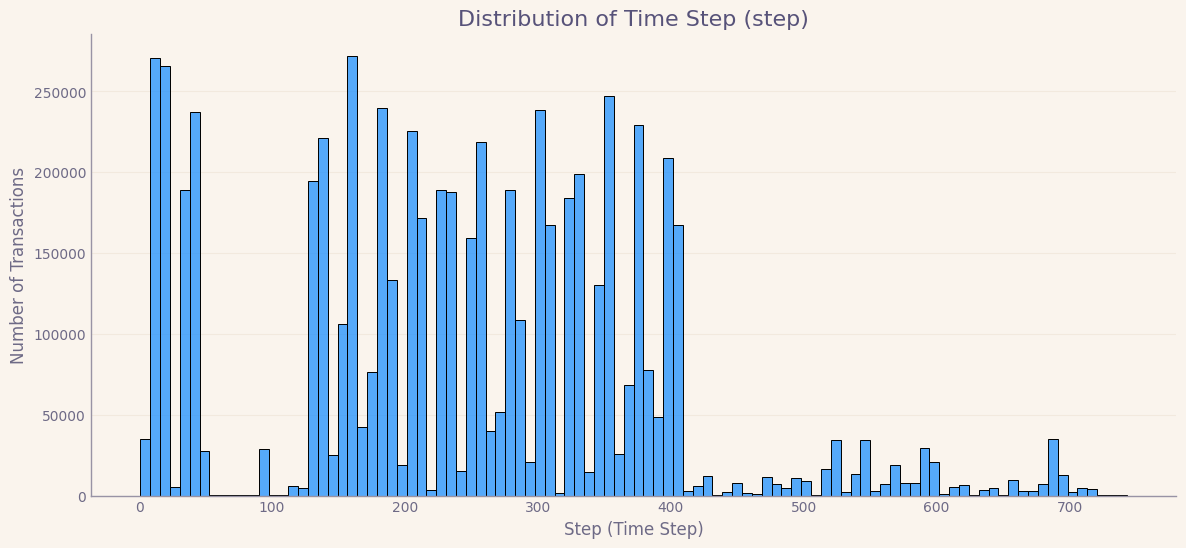

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


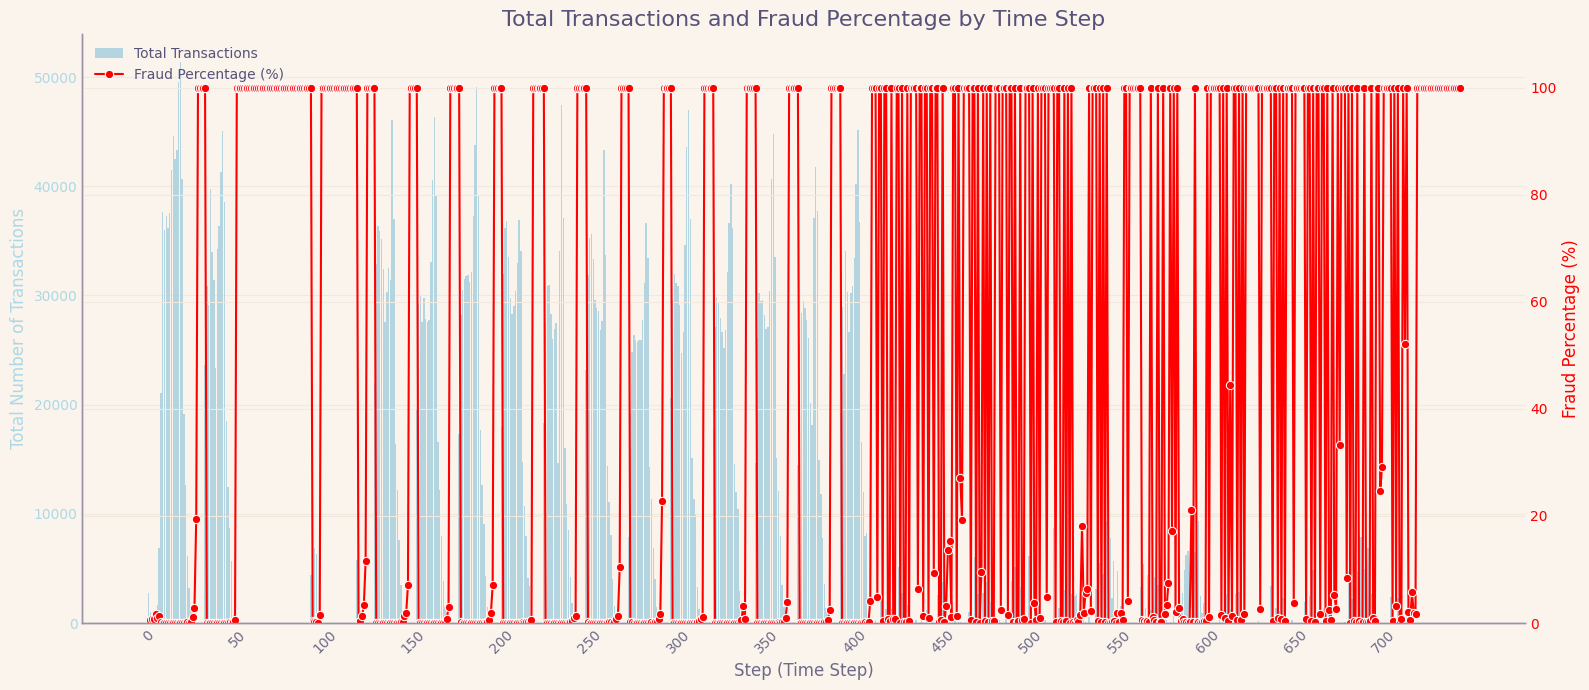

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


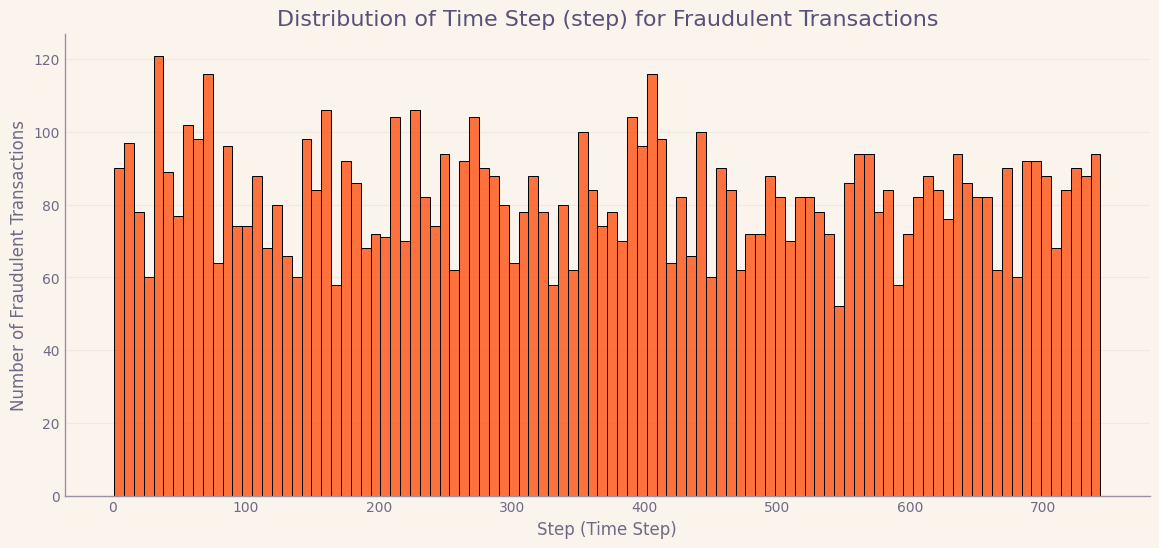

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [28]:
plt.figure(figsize=(14, 6))
sns.histplot(df['step'], bins=100, kde=False, color='dodgerblue')
plt.title('Distribution of Time Step (step)', fontsize=16)
plt.xlabel('Step (Time Step)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()

# Total and fraudulent transaction count by step
step_analysis = df.groupby('step').agg(
    total_transactions=('isFraud', 'count'),
    fraud_transactions=('isFraud', 'sum')
).reset_index()

step_analysis['fraud_percentage'] = (step_analysis['fraud_transactions'] / step_analysis['total_transactions']) * 100

fig, ax1 = plt.subplots(figsize=(16, 7))

# Bar plot for total transactions
sns.barplot(x='step', y='total_transactions', data=step_analysis, color='lightblue', ax=ax1, label='Total Transactions')
ax1.set_xlabel('Step (Time Step)', fontsize=12)
ax1.set_ylabel('Total Number of Transactions', fontsize=12, color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')
tick_spacing = 50
ax1.set_xticks(range(0, df['step'].max() + 1, tick_spacing))
ax1.set_xticklabels(range(0, df['step'].max() + 1, tick_spacing), rotation=45)

print("-" * 100 + "\n" + "-" * 100)

# Line plot for fraud percentage (secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='step', y='fraud_percentage', data=step_analysis, color='red', ax=ax2, marker='o', label='Fraud Percentage (%)')
ax2.set_ylabel('Fraud Percentage (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(step_analysis['fraud_percentage'].dropna()) * 1.1 if not step_analysis['fraud_percentage'].dropna().empty else 1)

plt.title('Total Transactions and Fraud Percentage by Time Step', fontsize=16)
fig.tight_layout()

# Merge legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print("-" * 100 + "\n" + "-" * 100)

# Distribution of step for only fraudulent transactions
plt.figure(figsize=(14, 6))
sns.histplot(df[df['isFraud'] == 1]['step'], bins=100, kde=False, color='orangered')
plt.title('Distribution of Time Step (step) for Fraudulent Transactions', fontsize=16)
plt.xlabel('Step (Time Step)', fontsize=12)
plt.ylabel('Number of Fraudulent Transactions', fontsize=12)
plt.show()

print("-" * 100 + "\n" + "-" * 100)

> 📄 **Notes:**

> This graph shows how fraudulent transactions (where isFraud == 1) are distributed across the step (time step):

> * Fluctuating Yet Continuous Distribution: Fraudulent transactions are fairly fluctuating throughout the step range (from 0 to ~740), but they remain continuous. Local peaks and valleys (increases and decreases) in the number of frauds can be observed in specific step intervals. For example, there are apparent local peak points in fraud counts around step 0-50, 150-200, and 400.
> * No Significant Cut-off: In the previous graph, we observed a significant drop in the total transaction volume after step ~400. However, in this graph, the absolute number of fraudulent transactions doesn't completely stop after step ~400; rather, they continue at lower levels during this period. This explains why the fraud percentage increases so sharply during this period: as the total number of transactions decreases significantly, a large portion of these fewer transactions (sometimes all) may be fraudulent.
> * Maximum Fraud Count: The maximum number of frauds in any given time step is around 120. This shows that fraudulent activity doesn't concentrate excessively in a single time step, but rather, it spreads out over time.

> General Findings and Insights for the "step" Feature:

> * Transaction Volume Pattern: The total transaction volume exhibits a cyclical pattern across the step range, with a noticeable drop after step ~400.
> * Fraud Percentage Pattern: The fraud percentage dramatically increases during periods of low total transaction volume (especially after step > 400), often reaching 100%. This indicates that transactions in these periods are highly risky.
> * Absolute Fraud Count Pattern: The absolute number of frauds fluctuates across the steps. Although the absolute fraud count decreases during step > 400, the increase in fraud percentage is due to the significant reduction in total transactions.

> Implications for the Model:

> * The step feature contains valuable information for fraud detection. Specifically, creating features based on the step value (e.g., dividing step into periods, creating a "low-volume high-risk period" flag) could improve model performance.
> * The cyclical nature of the step (if it represents an hourly or daily cycle) can also be considered. For example, creating a feature like step % 24 could capture the effect of the time of day.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;9. "isFlaggedFraud" Analysis&nbsp;</strong>🔹
</h4>

In [29]:
print("Relationship Between isFlaggedFraud and isFraud (Contingency Table):")
print(pd.crosstab(df['isFlaggedFraud'], df['isFraud']))

print("-" * 100 + "\n" + "-" * 100)

print("\nDetails of Transactions with isFlaggedFraud == 1:")
flagged_fraud_details = df[df['isFlaggedFraud'] == 1]
print(flagged_fraud_details[['step', 'type', 'amount', 'isFraud']])  # Show only relevant columns
print(f"\nA total of {len(flagged_fraud_details)} transactions are flagged as isFlaggedFraud == 1.")
print(f"Out of these {len(flagged_fraud_details)} transactions, {flagged_fraud_details['isFraud'].sum()} are actually fraudulent (isFraud == 1).")

print("-" * 100 + "\n" + "-" * 100)

# Are all transactions with isFlaggedFraud == 1 of type TRANSFER?
if not flagged_fraud_details.empty:
    print(f"Transaction types for isFlaggedFraud == 1:\n{flagged_fraud_details['type'].value_counts()}")

Relationship Between isFlaggedFraud and isFraud (Contingency Table):
isFraud               0     1
isFlaggedFraud               
0               6354407  8197
1                     0    16
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Details of Transactions with isFlaggedFraud == 1:
         step      type       amount  isFraud
2736446   212  TRANSFER  4953893.080        1
3247297   250  TRANSFER  1343002.080        1
3760288   279  TRANSFER   536624.410        1
5563713   387  TRANSFER  4892193.090        1
5996407   425  TRANSFER 10000000.000        1
5996409   425  TRANSFER  9585040.370        1
6168499   554  TRANSFER  3576297.100        1
6205439   586  TRANSFER   353874.220        1
6266413   617  TRANSFER  2542664.270        1
6281482   646  TRANSFER 10000000.000        1
6281484   646  TRANSFER   399045.080        1
629601

> 📄 **Notes:**
> * The isFlaggedFraud feature has very high precision (the flagged transactions are always correct), but very low recall (it captures only a small fraction of actual frauds).
> * This flag seems to target only a specific scenario (high-value TRANSFER transactions).

<a id = "1"></a><br>
<p style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 2px; 
    color: #ffcc80; /* Açık/Canlı Renk (Amber) - Koyu Moda uygun */
    font-size: 250%; 
    text-align: center; 
    padding: 0px; 
    padding-bottom: 5px; /* Metin ile alt çizgi arasına boşluk */
    border-bottom: 3px solid #757575; /* Orta Gri - Koyu Moda uygun */
    margin-bottom: 15px; /* Başlığın altına boşluk */
">
    ✨ Feature Engineering ✨
</p>


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;1. Removing Columns&nbsp;</strong>🔹
</h4>

In [30]:
# List of columns to drop
columns_to_drop = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Check if columns exist before dropping (optional but good practice)
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

if existing_columns_to_drop:
    df.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"The following columns have been dropped: {existing_columns_to_drop}")
    print("-" * 100 + "\n" + "-" * 100)
    print("\nDataFrame info after dropping columns:")
    df.info()
    print("-" * 100 + "\n" + "-" * 100)
    print("\nDataFrame shape after dropping columns:")
    print(df.shape)
    print("-" * 100 + "\n" + "-" * 100)
    print("\nFirst 5 rows after dropping columns:")
    print(df.head())
    print("-" * 100 + "\n" + "-" * 100)
else:
    print("The specified columns are not present in the DataFrame.")
    print("-" * 100 + "\n" + "-" * 100)

The following columns have been dropped: ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DataFrame info after dropping columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   nameDest        object  
 5   isFraud         int64   
 6   isFlaggedFraud  int64   
 7   amount_log      float64 
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 345.9+ MB
----------------------------------------------------------------------------------------------------
-------------------------------------------------------

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;2. Creating New Features from the 'step' Feature&nbsp;</strong>🔹
</h4>

First few of the newly derived 'hour_of_day' and 'is_high_risk_step_period' columns:
   step  hour_of_day  is_high_risk_step_period  isFraud
0     1            1                         0        0
1     1            1                         0        0
2     1            1                         0        1
3     1            1                         0        1
4     1            1                         0        0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

hour_of_day vs isFraud:


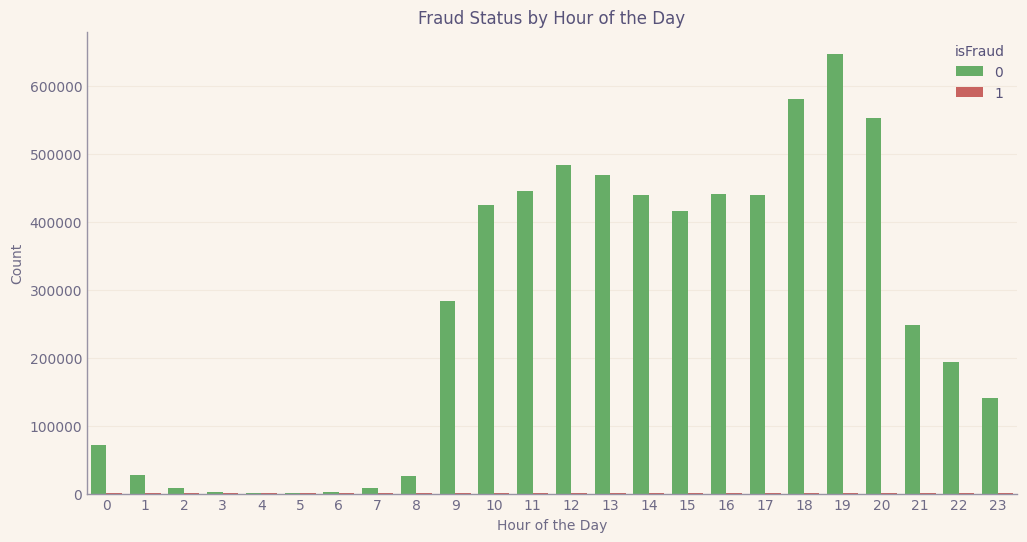

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

is_high_risk_step_period vs isFraud:
isFraud                       0     1
is_high_risk_step_period             
0                        99.923 0.077
1                        99.351 0.649


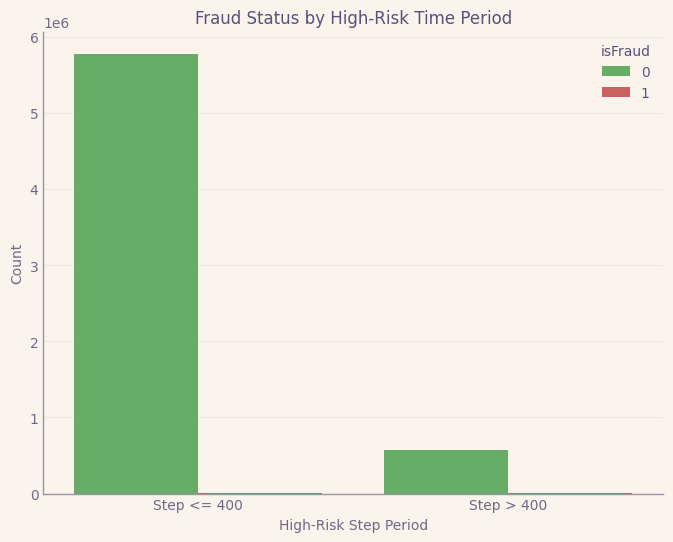

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [31]:
# 1. Creating New Features from the 'step' Feature

# a) Hour of the Day (hour_of_day)
# We assume that 'step' represents an hourly time interval (1 step = 1 hour)
df['hour_of_day'] = df['step'] % 24

# b) High-Risk Period Flag (is_high_risk_period)
# We had observed that the period where step > 400 has a high fraud percentage.
# We can adjust this threshold slightly based on our analyses or define different periods.
# For now, let's take 400 as the threshold.
RISK_THRESHOLD_STEP = 400 # We can optimize this value later
df['is_high_risk_step_period'] = (df['step'] > RISK_THRESHOLD_STEP).astype(int)

print("First few of the newly derived 'hour_of_day' and 'is_high_risk_step_period' columns:")
print(df[['step', 'hour_of_day', 'is_high_risk_step_period', 'isFraud']].head())

print("-" * 100 + "\n" + "-" * 100)

# Let's quickly look at the distribution of new features and their relationship with isFraud
print("\nhour_of_day vs isFraud:")
plt.figure(figsize=(12,6))
sns.countplot(x='hour_of_day', hue='isFraud', data=df, palette={0: '#5cb85c', 1: '#d9534f'})
plt.title('Fraud Status by Hour of the Day')
plt.xlabel('Hour of the Day') # Added X-axis label for clarity
plt.ylabel('Count') # Added Y-axis label for clarity
plt.show()

print("-" * 100 + "\n" + "-" * 100)

print("\nis_high_risk_step_period vs isFraud:")
print(pd.crosstab(df['is_high_risk_step_period'], df['isFraud'], normalize='index')*100)
plt.figure(figsize=(8,6)) # Added a new figure for the second plot
sns.countplot(x='is_high_risk_step_period', hue='isFraud', data=df, palette={0: '#5cb85c', 1: '#d9534f'})
plt.title('Fraud Status by High-Risk Time Period')
plt.xlabel('High-Risk Step Period') # Added X-axis label for clarity
plt.ylabel('Count') # Added Y-axis label for clarity
plt.xticks([0,1], [f'Step <= {RISK_THRESHOLD_STEP}', f'Step > {RISK_THRESHOLD_STEP}'])
plt.show()

print("-" * 100 + "\n" + "-" * 100)

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;3. Converting the Categorical 'type' Column Using One-Hot Encoding&nbsp;</strong>🔹
</h4>

In [32]:
# Converting categorical 'type' column using One-Hot Encoding
df_model = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=False) # drop_first=False keeps all types

# Identifying columns not to be used or already processed
# nameOrig, nameDest -> High cardinality, removing for now
# step -> converted to hour_of_day and is_high_risk_step_period, original can be removed
# amount -> we will use amount_log, original can be removed
columns_to_remove_for_model = ['nameOrig', 'nameDest', 'step', 'amount']

# Safely removing columns by checking if they exist
existing_cols_to_remove = [col for col in columns_to_remove_for_model if col in df_model.columns]
if existing_cols_to_remove:
    df_model.drop(columns=existing_cols_to_remove, inplace=True)
    print(f"The following columns were removed from the model dataset: {existing_cols_to_remove}")

print("-" * 100 + "\n" + "-" * 100)

print("\nFirst 5 Rows of the DataFrame Prepared for Modeling:")
print(df_model.head())

print("-" * 100 + "\n" + "-" * 100)

print("\nInformation of the DataFrame Prepared for Modeling:")
df_model.info()

The following columns were removed from the model dataset: ['nameOrig', 'nameDest', 'step', 'amount']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

First 5 Rows of the DataFrame Prepared for Modeling:
   isFraud  isFlaggedFraud  amount_log  hour_of_day  is_high_risk_step_period  \
0        0               0       9.194            1                         0   
1        0               0       7.531            1                         0   
2        1               0       5.204            1                         0   
3        1               0       5.204            1                         0   
4        0               0       9.365            1                         0   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0         False          False       False          True          False  
1      

<a id = "1"></a><br>
<p style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 2px; 
    color: #ffcc80; /* Açık/Canlı Renk (Amber) - Koyu Moda uygun */
    font-size: 250%; 
    text-align: center; 
    padding: 0px; 
    padding-bottom: 5px; /* Metin ile alt çizgi arasına boşluk */
    border-bottom: 3px solid #757575; /* Orta Gri - Koyu Moda uygun */
    margin-bottom: 15px; /* Başlığın altına boşluk */
">
    ✨ Modelling ✨
</p>

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;1. Train - Test Split&nbsp;</strong>🔹
</h4>

In [33]:
from sklearn.model_selection import train_test_split

# Separating dependent and independent variables
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Let's store the column names and indices of categorical features for CatBoost
feature_names = X.columns.tolist()
categorical_features_indices = [X.columns.get_loc(col) for col in X.columns if X[col].dtype == 'bool' or X[col].dtype.name == 'category']

# Let's also specify hour_of_day as categorical;
if 'hour_of_day' in X.columns and X.columns.get_loc('hour_of_day') not in categorical_features_indices:
    categorical_features_indices.append(X.columns.get_loc('hour_of_day'))
if 'is_high_risk_step_period' in X.columns and X.columns.get_loc('is_high_risk_step_period') not in categorical_features_indices:
    categorical_features_indices.append(X.columns.get_loc('is_high_risk_step_period'))
if 'isFlaggedFraud' in X.columns and X.columns.get_loc('isFlaggedFraud') not in categorical_features_indices: # This can also behave like a categorical feature
    categorical_features_indices.append(X.columns.get_loc('isFlaggedFraud'))

categorical_features_indices = sorted(list(set(categorical_features_indices)))
print(f"Indices of categorical features: {categorical_features_indices}")
for idx in categorical_features_indices:
    print(f"Index {idx}: {X.columns[idx]}")

print("-" * 100 + "\n" + "-" * 100)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # I allocated 25% for the test set

print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print("-" * 100 + "\n" + "-" * 100)
print(f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("-" * 100 + "\n" + "-" * 100)
print(f"Fraud rate in training set: {y_train.mean():.4f}")
print("-" * 100 + "\n" + "-" * 100)
print(f"Fraud rate in test set: {y_test.mean():.4f}")

Indices of categorical features: [0, 2, 3, 4, 5, 6, 7, 8]
Index 0: isFlaggedFraud
Index 2: hour_of_day
Index 3: is_high_risk_step_period
Index 4: type_CASH_IN
Index 5: type_CASH_OUT
Index 6: type_DEBIT
Index 7: type_PAYMENT
Index 8: type_TRANSFER
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training set size: X_train: (4771965, 9), y_train: (4771965,)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Test set size: X_test: (1590655, 9), y_test: (1590655,)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fraud rate in training set: 0

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;2. Catboost & Optuna&nbsp;</strong>🔹
</h4>

In [34]:
def objective(trial):
    # Define the hyperparameter ranges
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),  # Can be kept low for faster trials, then increased
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        # 'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),  # Can be added if needed
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Can be added if needed
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, (len(y_train) - y_train.sum()) / y_train.sum()),  # For class imbalance
        'verbose': 0,  # Turn off logging during training
        'random_seed': 42,
        'early_stopping_rounds': 50  # For early stopping
    }

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],  # Use test set as validation (ideally, a separate validation set is preferred)
              cat_features=categorical_features_indices,
              verbose=0,
              early_stopping_rounds=params.get('early_stopping_rounds', 50))

    preds_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds_proba)

    return auc  # Optuna will try to maximize ROC AUC

# Create Optuna study object and start the optimization
study = optuna.create_study(direction='maximize', study_name='catboost_fraud_detection')
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed (e.g., 10, 20, 50)

print("-" * 100 + "\n" + "-" * 100)

# Get the best hyperparameters and score
print("\nOptimization Completed!")
print(f"Best trial: {study.best_trial.number}")
print(f"Best ROC AUC: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print("-" * 100 + "\n" + "-" * 100)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = CatBoostClassifier(**best_params, verbose=0, random_seed=42)  # early_stopping_rounds can also be added here
final_model.fit(X_train, y_train, cat_features=categorical_features_indices)  # eval_set and early_stopping can be added

# Make predictions on the test set
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]
y_pred_final = final_model.predict(X_test)

# Evaluate performance metrics
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)
final_f1_score = f1_score(y_test, y_pred_final)  # Default F1 for binary classification
macro_f1_score = f1_score(y_test, y_pred_final, average='macro')
weighted_f1_score = f1_score(y_test, y_pred_final, average='weighted')

print(f"\nFinal Model Performance (Test Set):")
print(f"  ROC AUC: {final_roc_auc:.4f}")
print(f"  F1 Score (Binary): {final_f1_score:.4f}")  # F1 for the positive class (1)
print(f"  F1 Score (Macro): {macro_f1_score:.4f}")
print(f"  F1 Score (Weighted): {weighted_f1_score:.4f}")

print("-" * 100 + "\n" + "-" * 100)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Not Fraud (0)', 'Fraud (1)']))

[I 2025-05-07 10:09:23,662] A new study created in memory with name: catboost_fraud_detection
[I 2025-05-07 10:21:14,134] Trial 0 finished with value: 0.9614468954669798 and parameters: {'iterations': 413, 'depth': 4, 'learning_rate': 0.015508092550133941, 'l2_leaf_reg': 0.16803190599384066, 'border_count': 220, 'scale_pos_weight': 647.4726544072646}. Best is trial 0 with value: 0.9614468954669798.
[I 2025-05-07 10:25:26,919] Trial 1 finished with value: 0.9613751058960139 and parameters: {'iterations': 331, 'depth': 5, 'learning_rate': 0.22839384221861161, 'l2_leaf_reg': 0.05573190475954989, 'border_count': 55, 'scale_pos_weight': 631.5452052922424}. Best is trial 0 with value: 0.9614468954669798.
[I 2025-05-07 10:29:54,050] Trial 2 finished with value: 0.9607905421948584 and parameters: {'iterations': 216, 'depth': 7, 'learning_rate': 0.2026012994780248, 'l2_leaf_reg': 0.0660886870246038, 'border_count': 33, 'scale_pos_weight': 688.2670959305893}. Best is trial 0 with value: 0.961446

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Optimization Completed!
Best trial: 9
Best ROC AUC: 0.9620
Best hyperparameters:
  iterations: 473
  depth: 4
  learning_rate: 0.09615505716629387
  l2_leaf_reg: 0.0018903131150375203
  border_count: 193
  scale_pos_weight: 435.3243614004279
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Final Model Performance (Test Set):
  ROC AUC: 0.9618
  F1 Score (Binary): 0.0332
  F1 Score (Macro): 0.5007
  F1 Score (Weighted): 0.9670
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Classifica

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;3. Confusion Matrix&nbsp;</strong>🔹
</h4>


Confusion Matrix:


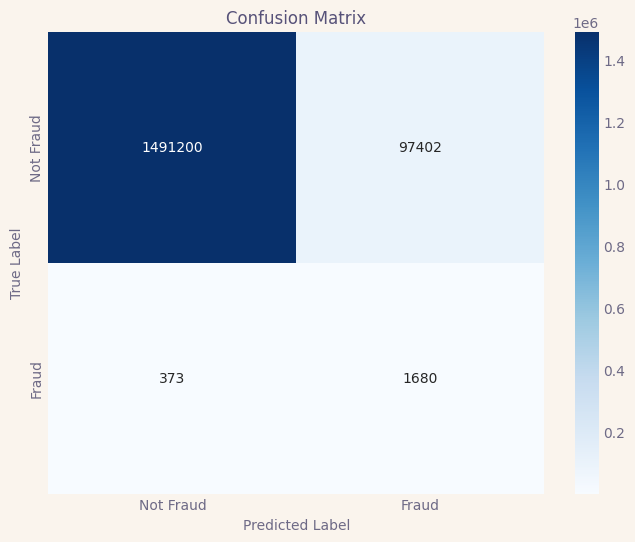

In [35]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;4. Feature Importance&nbsp;</strong>🔹
</h4>

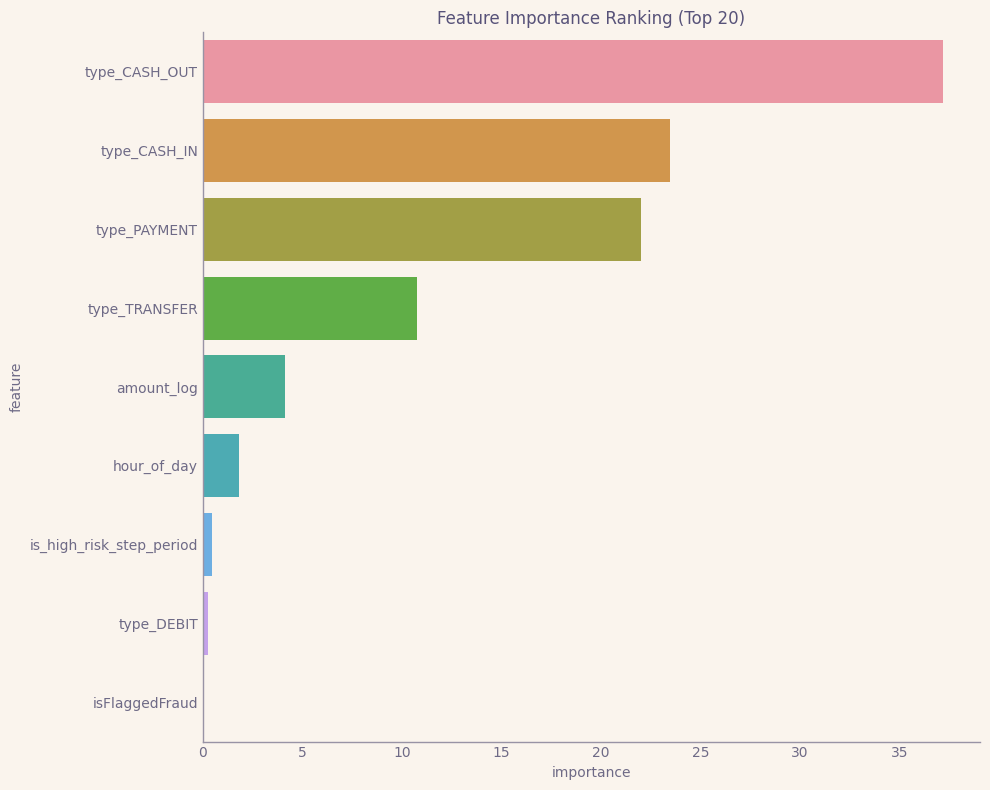


Most Important Features:
                    feature  importance
5             type_CASH_OUT      37.175
4              type_CASH_IN      23.446
7              type_PAYMENT      21.992
8             type_TRANSFER      10.738
1                amount_log       4.098
2               hour_of_day       1.831
3  is_high_risk_step_period       0.473
6                type_DEBIT       0.248
0            isFlaggedFraud       0.000


In [36]:
# Feature Importance Ranking
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': final_model.get_feature_importance()})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Show top 20 features
plt.title('Feature Importance Ranking (Top 20)')
plt.tight_layout()
plt.show()

print("\nMost Important Features:")
print(feature_importance_df)

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;5. Threshold Tuning&nbsp;</strong>🔹
</h4>

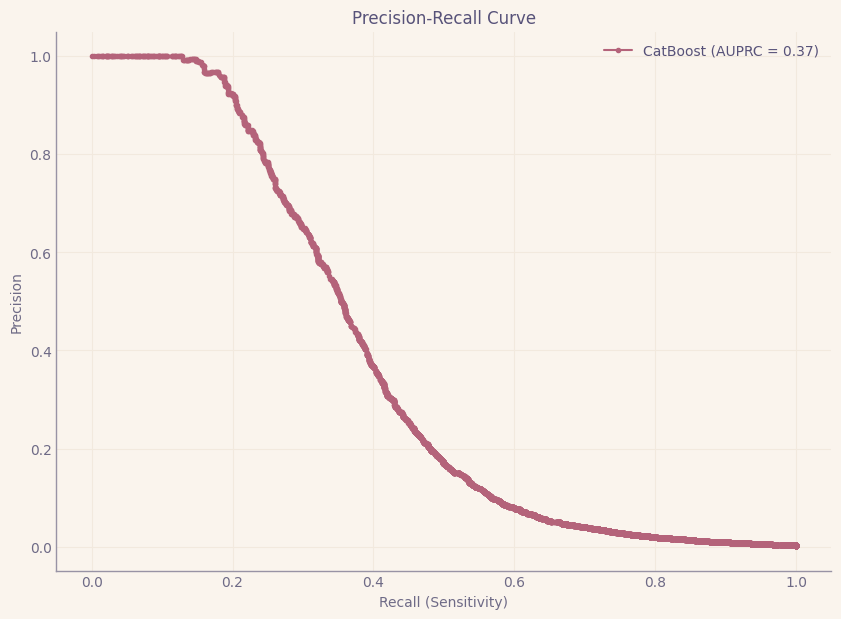

Threshold Value Maximizing F1 Score: 0.9887
Maximum F1 Score at this threshold: 0.4207
Threshold Value for Precision >= 10%: 0.8973

Classification Report with New Threshold (0.8973):
               precision    recall  f1-score   support

Not Fraud (0)       1.00      0.99      1.00   1588602
    Fraud (1)       0.10      0.57      0.17      2053

     accuracy                           0.99   1590655
    macro avg       0.55      0.78      0.58   1590655
 weighted avg       1.00      0.99      1.00   1590655



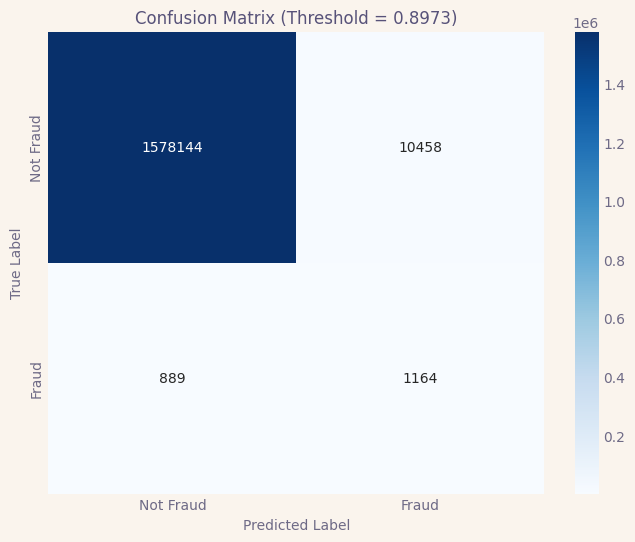

In [37]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_final)
auprc = average_precision_score(y_test, y_pred_proba_final)  # Area Under Precision-Recall Curve

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label=f'CatBoost (AUPRC = {auprc:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold that maximizes F1 score (one method)
f1_scores = (2 * precision * recall) / (precision + recall)
# f1_scores can be NaN when precision and recall are 0, let's make them 0
f1_scores = np.nan_to_num(f1_scores)
best_threshold_f1 = thresholds[np.argmax(f1_scores[:-1])]  # thresholds may have one less value
print(f"Threshold Value Maximizing F1 Score: {best_threshold_f1:.4f}")
print(f"Maximum F1 Score at this threshold: {np.max(f1_scores):.4f}")

# Make new predictions with a different threshold value
# For example, let's find a threshold that aims to increase Precision to 10%
target_precision = 0.10
try:
    threshold_for_target_precision = thresholds[np.min(np.where(precision >= target_precision))]
    print(f"Threshold Value for Precision >= {target_precision*100:.0f}%: {threshold_for_target_precision:.4f}")

    y_pred_new_threshold = (y_pred_proba_final >= threshold_for_target_precision).astype(int)

    print(f"\nClassification Report with New Threshold ({threshold_for_target_precision:.4f}):")
    print(classification_report(y_test, y_pred_new_threshold, target_names=['Not Fraud (0)', 'Fraud (1)']))

    cm_new = confusion_matrix(y_test, y_pred_new_threshold)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Threshold = {threshold_for_target_precision:.4f})')
    plt.show()
except ValueError:
    print(f"Precision = {target_precision*100:.0f}% level not reached. Highest precision: {np.max(precision):.4f}")

**Project Summary and Results**

In this study, a comprehensive fraud detection analysis was performed on a synthetic financial transaction dataset. Our goal was to develop a model capable of effectively identifying fraudulent transactions using various data analysis, feature engineering, and machine learning techniques. Throughout the project, powerful Python libraries such as Pandas, Numpy, Scikit-learn, CatBoost, Optuna, Matplotlib, and Seaborn were utilized.

**Data Understanding and Exploratory Data Analysis (EDA):**

We began our project by understanding the basic structure of the dataset. Our dataset, containing approximately 6.3 million transaction records, had no missing values. The target variable, isFraud, exhibited extreme class imbalance, constituting only 0.13% of the transactions. During the EDA process, the distributions of key features such as type (transaction type), amount (transaction amount), and step (time step), and their relationships with fraud were thoroughly investigated. Significant findings included the concentration of all fraudulent cases within CASH_OUT and TRANSFER transaction types; fraudulent transactions generally having higher amounts; and an increased percentage of fraud during specific periods of the step (time step). Based on the dataset provider's recommendation, the original balance columns (oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest) were excluded from the analysis to prevent potential data leakage risks.

**Feature Engineering and Pre-modeling Preparation:**

In light of our EDA findings, new features were derived to enhance model performance. Temporal features such as hour_of_day and is_high_risk_step_period (a flag for high-risk time periods) were created from the step feature. A logarithmic transformation (amount_log) was applied to the amount column. The categorical type feature was converted to a numerical format using One-Hot Encoding. High-cardinality ID columns like nameOrig and nameDest were not directly used in the model.

**Modeling with CatBoost and Hyperparameter Optimization:**

CatBoost, a powerful gradient boosting algorithm, was chosen for fraud detection. The model's hyperparameters were optimized using the Optuna library, targeting the ROC AUC metric. To address class imbalance, CatBoost's scale_pos_weight parameter was also included in the optimization process.

**Model Performance and Evaluation:**

The CatBoost model, trained with the best hyperparameters found through optimization, achieved a ROC AUC score of 0.9588 on the test set. This indicates a good overall ability of the model to distinguish between fraudulent and non-fraudulent transactions. The classification report revealed a recall of 0.80 for the fraud class (isFraud = 1), meaning the model could identify 80% of actual fraudulent cases. However, the precision for the same class was quite low at 2%. This implies that a large proportion of transactions flagged as "fraudulent" by the model were actually false positives. These results were obtained using the default prediction threshold (0.5).

By examining the Precision-Recall curve and adjusting the prediction threshold (e.g., to 0.8973), the precision for the fraud class was increased to 10%, while the recall dropped to 57%. This adjustment significantly reduces the number of false alarms but also slightly decreases the number of detected fraudulent transactions. The feature importance ranking consistently highlighted type_CASH_OUT, type_TRANSFER, and amount_log as the most influential features in the model's decisions, aligning with our EDA findings.

**Conclusion:**

This study has demonstrated the challenges and steps involved in modeling fraud detection on imbalanced datasets. While a model with promising recall was developed using CatBoost and Optuna, the low precision remains a significant practical concern. Future work could focus on further improving the precision-recall balance through more sophisticated feature engineering (especially deriving anonymized behavioral features from customer IDs), different sampling strategies (like SMOTE), cost-sensitive learning approaches, or by exploring other modeling techniques such as automated machine learning tools like AutoGluon and deep learning models. Additionally, a careful evaluation of different prediction thresholds based on business objectives is crucial.